In [1]:
import sys
sys.path.append('/mnt/d/ariel2/code/core/')
sys.path.append('d:/ariel2/code/core/')
sys.path.append('/kaggle/input/my-ariel2-library')
import kaggle_support as kgs
import ariel_model
import ariel_numerics
import ariel_gp
import ariel_load
import time
import numpy as np
import multiprocess
import importlib
import copy
import cupy as cp
import matplotlib.pyplot as plt
from tqdm import tqdm
import gp

local


In [2]:
%matplotlib widget

In [3]:
train_data = kgs.load_all_train_data()

In [4]:
dat_example = copy.deepcopy(train_data[0])
dat_example.load_to_step(5, ariel_load.default_loaders())

In [5]:
kgs.debugging_mode = 1
model = ariel_gp.PredictionModel()
model.run_in_parallel = False
model.model_options.n_iter=0
model.model_options.use_training_labels = True
model.train(train_data)
model.infer(train_data[0:1]);


In [6]:
if False:   
    loaded_res = kgs.dill_load(kgs.temp_dir + '/prep2.pickle')
    FGS_noise = []
    AIRS_noise = []
    FGS_transits = []
    AIRS_transits = []
    brightness = []
    prior_sigma= []
    for d,r in tqdm(zip(train_data,loaded_res)):
        mm= copy.deepcopy(model.results['model_mean'])
        mm= copy.deepcopy(model.results['model_mean'])
        mm.m['signal'].m['main'].m['transit'].transit_params[0][0] = d.transit_params
        mm.m['signal'].m['main'].m['transit'].transit_params[0][0].u = [0,0]
        mm.m['signal'].m['main'].m['transit'].transit_params[0][1] = d.transit_params
        mm.m['signal'].m['main'].m['transit'].transit_params[0][1].u = [0,0]
        mm.set_parameters(r[0])
        mm.m['signal'].m['main'].m['transit'].depth_model.offset = -d.diagnostics['training_spectrum']
        
        dd=copy.deepcopy(d)
        dd.load_to_step(5, model.starter_model.loaders)
        
        obs_noise = copy.deepcopy(model.results['obs'])
        noise_labels = mm.m['noise'].get_prediction(obs_noise)
        obs_noise.labels= noise_labels
        FGS_noise.append(obs_noise.export_matrix(False))
        AIRS_noise.append(obs_noise.export_matrix(True))
        
        obs_transit = copy.deepcopy(model.results['obs'])
        stellar_labels = mm.m['signal'].m['main'].m['spectrum'].get_prediction(obs_transit)
        transit_labels = mm.m['signal'].m['main'].m['transit'].get_prediction(obs_transit)
        obs_transit.labels = stellar_labels*transit_labels
        FGS_transits.append(obs_transit.export_matrix(False))
        AIRS_transits.append(obs_transit.export_matrix(True))
        
        prior_sigma.append(mm.m['noise'].model.sigma_varying)
        
        brightness.append(np.mean(stellar_labels))
    del mm
    del loaded_res  
    FGS_noise = np.array(np.stack(FGS_noise))
    AIRS_noise = np.array(np.stack(AIRS_noise))
    FGS_transits = np.array(np.stack(FGS_transits))
    AIRS_transits = np.array(np.stack(AIRS_transits))
    brightness = np.array(brightness)
    kgs.dill_save(kgs.temp_dir + 'noise_analysis.pickle', (FGS_noise, AIRS_noise, FGS_transits, AIRS_transits, brightness, prior_sigma))
      
(FGS_noise, AIRS_noise, FGS_transits, AIRS_transits, brightness, prior_sigma) = kgs.dill_load(kgs.temp_dir + 'noise_analysis.pickle')

[1.0002984920432865, 0.997885833491171]
[-9.627462080549108e-07, 8.038060217434376e-06]
[2.26722982586936, 1.9443303436819726]
Score:           0.6009
RMS error FGS:   209.82 ppm
mRMS error FGS:  63.31 ppm
RMS error AIRS:  154.91 ppm
mRMS error AIRS: 59.65 ppm

20
Score:           0.6320
RMS error FGS:   84.90 ppm
mRMS error FGS:  49.72 ppm
RMS error AIRS:  66.35 ppm
mRMS error AIRS: 57.88 ppm
No fudge
Score:           0.4968
RMS error FGS:   209.82 ppm
mRMS error FGS:  63.31 ppm
RMS error AIRS:  154.91 ppm
mRMS error AIRS: 59.65 ppm


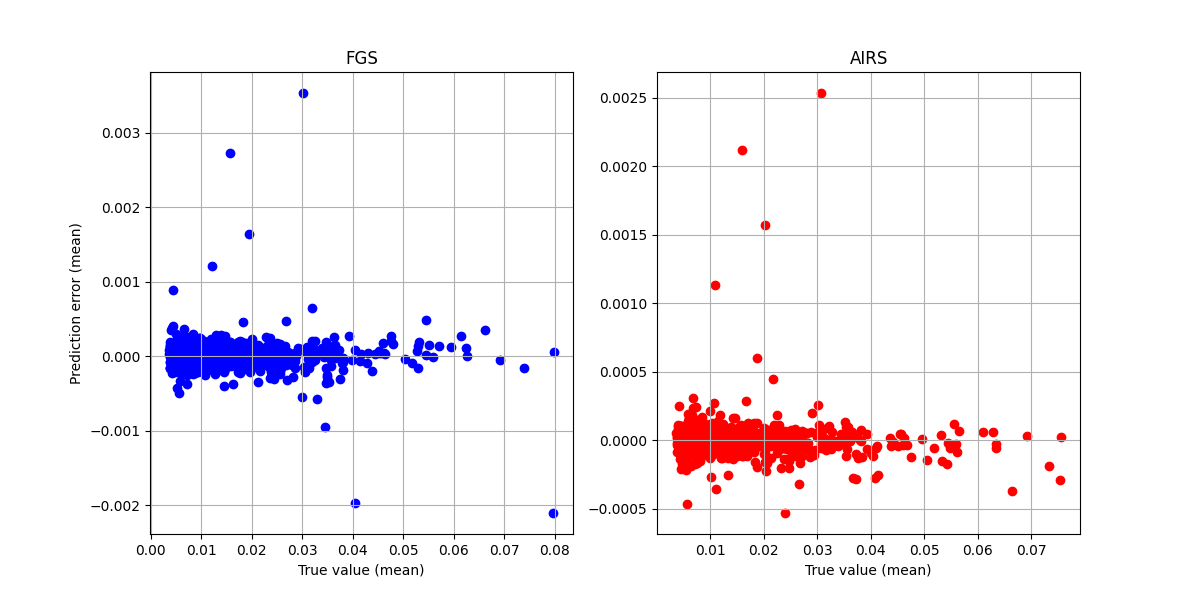

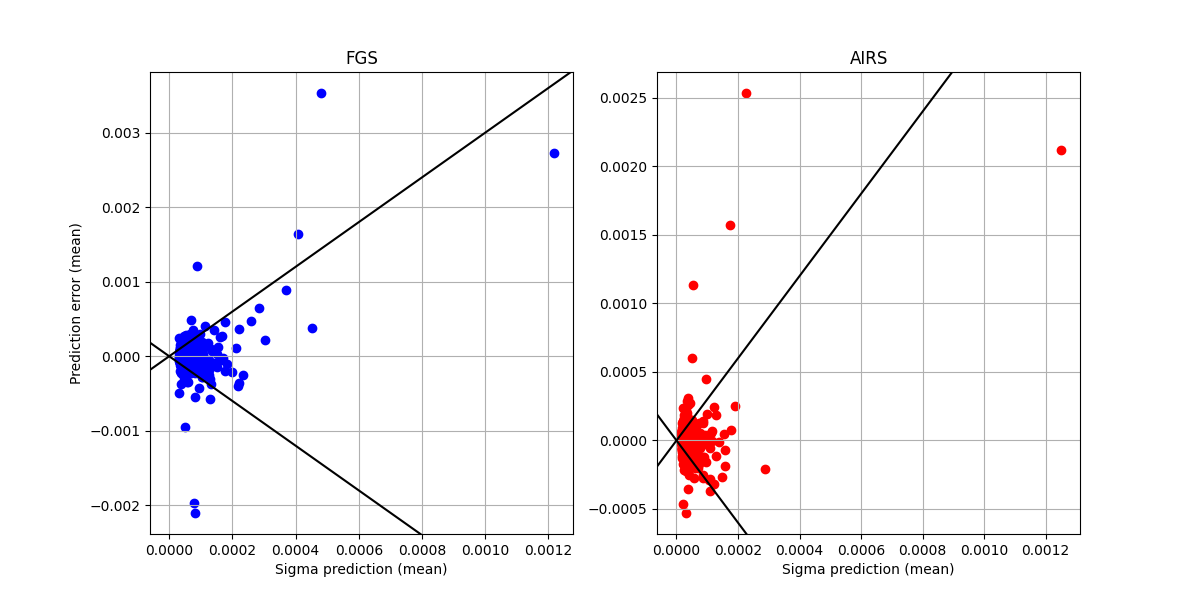

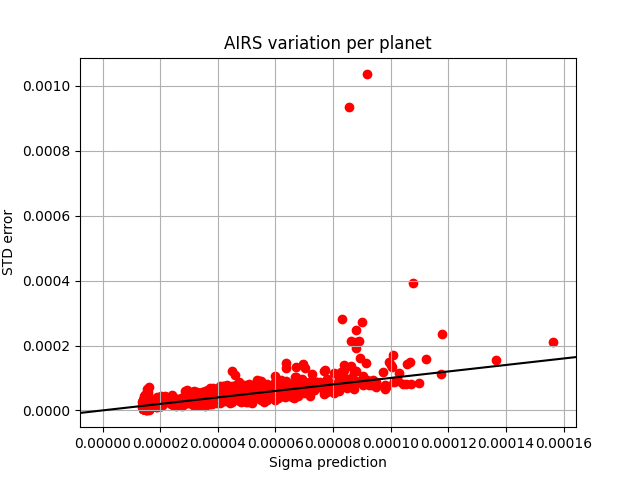

In [7]:
kgs.debugging_mode=0
plt.close('all')
def basics():
    plt.grid(True)
    plt.box(True)    
def plot_two_sensors(func, xl, yl, mod):
    _,ax = plt.subplots(1,2,figsize=(12,6))
    plt.sca(ax[0]);
    plt.title('FGS')
    plt.xlabel(xl)
    plt.ylabel(yl)
    sc=func(slice(0,1), 'blue', 'FGS')
    kgs.add_cursor(sc)
    basics();mod()
    
    plt.sca(ax[1]);
    plt.title('AIRS')
    plt.xlabel(xl)
    sc=func(slice(1,283), 'red', 'AIRS')
    kgs.add_cursor(sc)
    basics();mod()
    
    plt.pause(0.001)

def report_extreme_ratios(x,y,name):
    return
    print(name)
    inds = np.argsort(np.abs(y/x))[::-1]
    for ii in inds[:10]:
        print(f'{inferred_data[ii].planet_id}, ratio:{np.abs(y[ii]/x[ii]):.3f}, x:{x[ii]:.3e}, y:{y[ii]:.3e}, RMS:{kgs.rms(error_matrix[ii,:]):.3e}')

def fname(k):
    return kgs.temp_dir + 'evaluate_model_'+k+'__'+str(1099)+'.pickle'
(inferred_data,model2,_) = kgs.dill_load(fname('New baseline'))
train_data_here = train_data
inferred_data = inferred_data[:len(train_data)]
#model.bias_a[0]+=0.006
#model.bias_a[1]-=0.0002
#inferred_data = model.infer(train_data)
#print(k)
print(model2.bias_a)
print(model2.bias_b)
print(model2.sigma_fudge)
kgs.score_metric(inferred_data, train_data_here)
print('')
print('20')
kgs.score_metric(inferred_data[:20], train_data_here[:20]) 
# print('')
print('No fudge')
model2.sigma_fudge = [1,1]
#model.bias_a = [1,1]
#model.bias_b = [0,0]
# print('!!!')
inferred_data = model2.infer(train_data)
kgs.score_metric(inferred_data, train_data_here)     
error_matrix = np.array([d.spectrum - t.spectrum for d,t in zip(inferred_data,train_data_here)])
true_matrix = np.array([t.spectrum for d,t in zip(inferred_data,train_data_here)])

def plot_prediction_vs_true(slic, col, name):
    x = np.mean(true_matrix[:,slic],1)
    y = np.mean(error_matrix[:,slic],1)
    sc=plt.scatter(x,y,color = col)
    report_extreme_ratios(x,y,name)
    return sc

plot_two_sensors(plot_prediction_vs_true, 'True value (mean)', 'Prediction error (mean)', lambda:0)

def plot_mean_error_vs_sigma(slic,col, name):
    x = [np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data]
    y = np.mean(error_matrix[:,slic],1)
    sc=plt.scatter(x,y,color = col)
    report_extreme_ratios(x,y,name)
    return sc
def mod():
    plt.axline((0,0), slope=3, color='black')
    plt.axline((0,0), slope=-3, color = 'black')        
plot_two_sensors(plot_mean_error_vs_sigma, 'Sigma prediction (mean)', 'Prediction error (mean)', mod)

#     def plot_mean_error_vs_sigma(slic,col, name):
#         x = np.mean(true_matrix[:,slic],1)
#         y = np.mean(error_matrix[:,slic],1) / np.array([np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data])
#         plt.scatter(x,y,color = col)
#         report_extreme_ratios(x,y,name)    
#     plot_two_sensors(plot_mean_error_vs_sigma, 'True value (mean)', 'Prediction error / sigma (mean)', lambda:0)

# def plot_mean_error_vs_sigma(slic,col, name):
#     x = np.sqrt([(np.trace(d.spectrum_cov[1:,1:]) - np.sum(d.spectrum_cov[1:,1:]) / n) / n for d in inferred_data])
#     y = np.mean(error_matrix[:,slic],1) / np.array([np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data])
#     #y = np.mean(error_matrix[:,slic],1)
#     plt.scatter(x,y,color = col)
#     report_extreme_ratios(x,y,name)    
# plot_two_sensors(plot_mean_error_vs_sigma, 'AIRS variation per planet', 'Prediction error / sigma (mean)', lambda:0)

plt.figure(); 
plt.title('AIRS variation per planet')
plt.xlabel('Sigma prediction')
plt.ylabel('STD error')
n=282
x=np.sqrt([(np.trace(d.spectrum_cov[1:,1:]) - np.sum(d.spectrum_cov[1:,1:]) / n) / n for d in inferred_data])
y=np.sqrt(np.var(error_matrix[:,1:],1))
sc=plt.scatter(x, y, color='red')
kgs.add_cursor(sc)
basics()
plt.axline((0,0), slope=1, color='black')
#report_extreme_ratios(x,y,'AIRS variation')    
plt.pause(0.001)

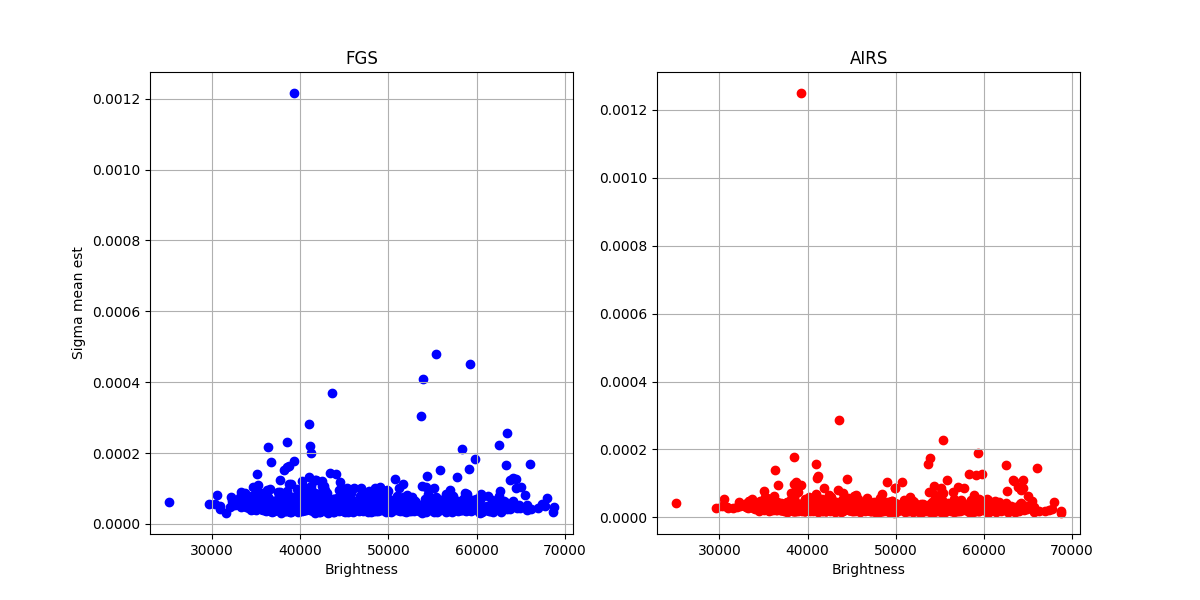

In [8]:
def plot_things(slic, col, name):
    x = brightness
    y = [np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data]
    sc=plt.scatter(x,y,color = col)
    report_extreme_ratios(x,y,name)
    return sc

plot_two_sensors(plot_things, 'Brightness', 'Sigma mean est', lambda:0)

490 4.228341403572835e-05 -1.384261353091533e-05 -0.3273769123566676


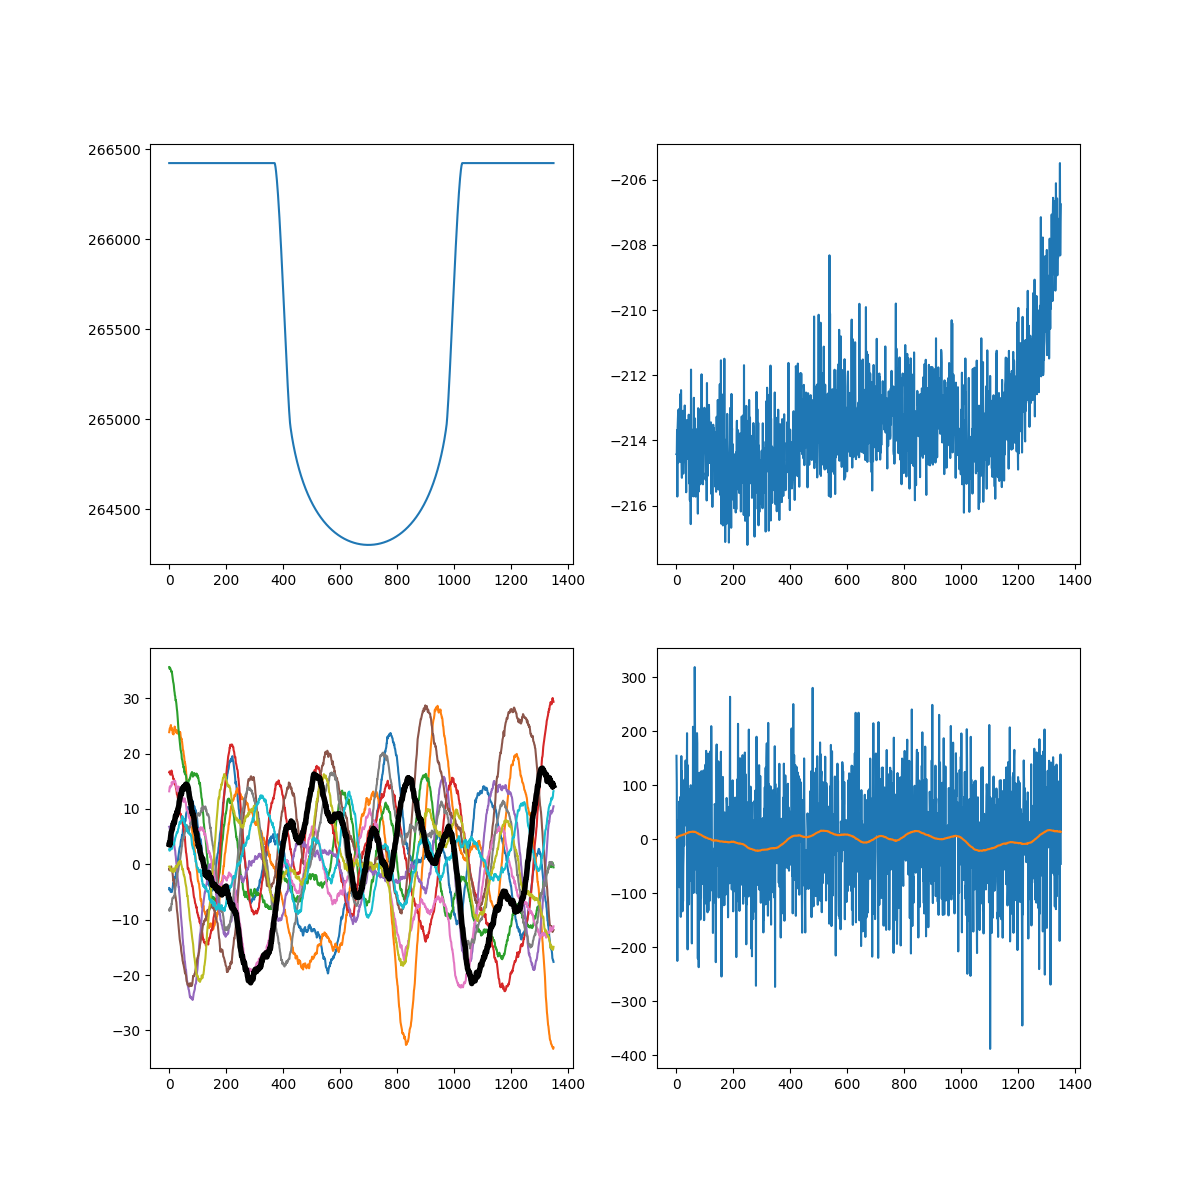

In [9]:
from IPython.display import display
import ariel_load_FGS
importlib.reload(ariel_load_FGS)
#plt.close('all')
slic = slice(0,1)
fgs_sigma_est = [np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data]
fgs_error = np.mean(error_matrix[:,slic],1)
fgs_ratio = fgs_error/fgs_sigma_est
order = np.argsort(fgs_ratio)[::-1]
fgs_ratio[order]
for ind in [490]:
    #if fgs_sigma_est[ind]<0.00005:
    print(ind, fgs_sigma_est[ind], fgs_error[ind], fgs_ratio[ind])
    fig,ax = plt.subplots(2,2,figsize=(12,12))
    plt.sca(ax[0,0])
    plt.plot(FGS_transits[ind,...])
    plt.sca(ax[1,1])
    plt.plot(FGS_noise[ind,...])
    XX=(30,0.001)
    plt.plot(kgs.gaussian_2D_filter_with_nans(FGS_noise[ind,...],XX))
    sigma = prior_sigma[ind][0]/np.sqrt(dat_example.transits[0].data[0].time_intervals[0].get())
    artificial_noise = np.random.default_rng(seed=ind).normal(0,sigma,[10,FGS_noise[ind,...].shape[0]])
    # plt.figure()
    # plt.plot(artificial_noise.T)
    plt.sca(ax[1,0])
    for ii in range(10):
        plt.plot(kgs.gaussian_2D_filter_with_nans(artificial_noise[[ii],...].T,XX))
    plt.plot(kgs.gaussian_2D_filter_with_nans(FGS_noise[ind,...],XX), color='black', linewidth=4)
    d=copy.deepcopy(train_data[ind])
    loaders = ariel_load.default_loaders()
    #loaders[0].cache_steps=[]
    d.load_to_step(5,loaders)
    plt.sca(ax[0,1])
    plt.plot(d.transits[0].diagnostics['FGS_jitter'])
    plt.show()
    #display(fig)
    #fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    fig.canvas.draw_idle()
    # y = FGS_noise[ind,...]
    # dm=model.results['model_mean'].m['signal'].m['main'].m['drift'].m['FGS'].model.m['average'].basis_functions
    # coeffs = np.linalg.lstsq(dm, y, rcond=None)
    # transit_filtered = dm@coeffs[0]
    #plt.plot(transit_filtered)
    #plt.pause(0.001)

490 2.1140518762587748e-05 0.0002381000172467979 11.26273294996725
(1125,) (1125, 4)


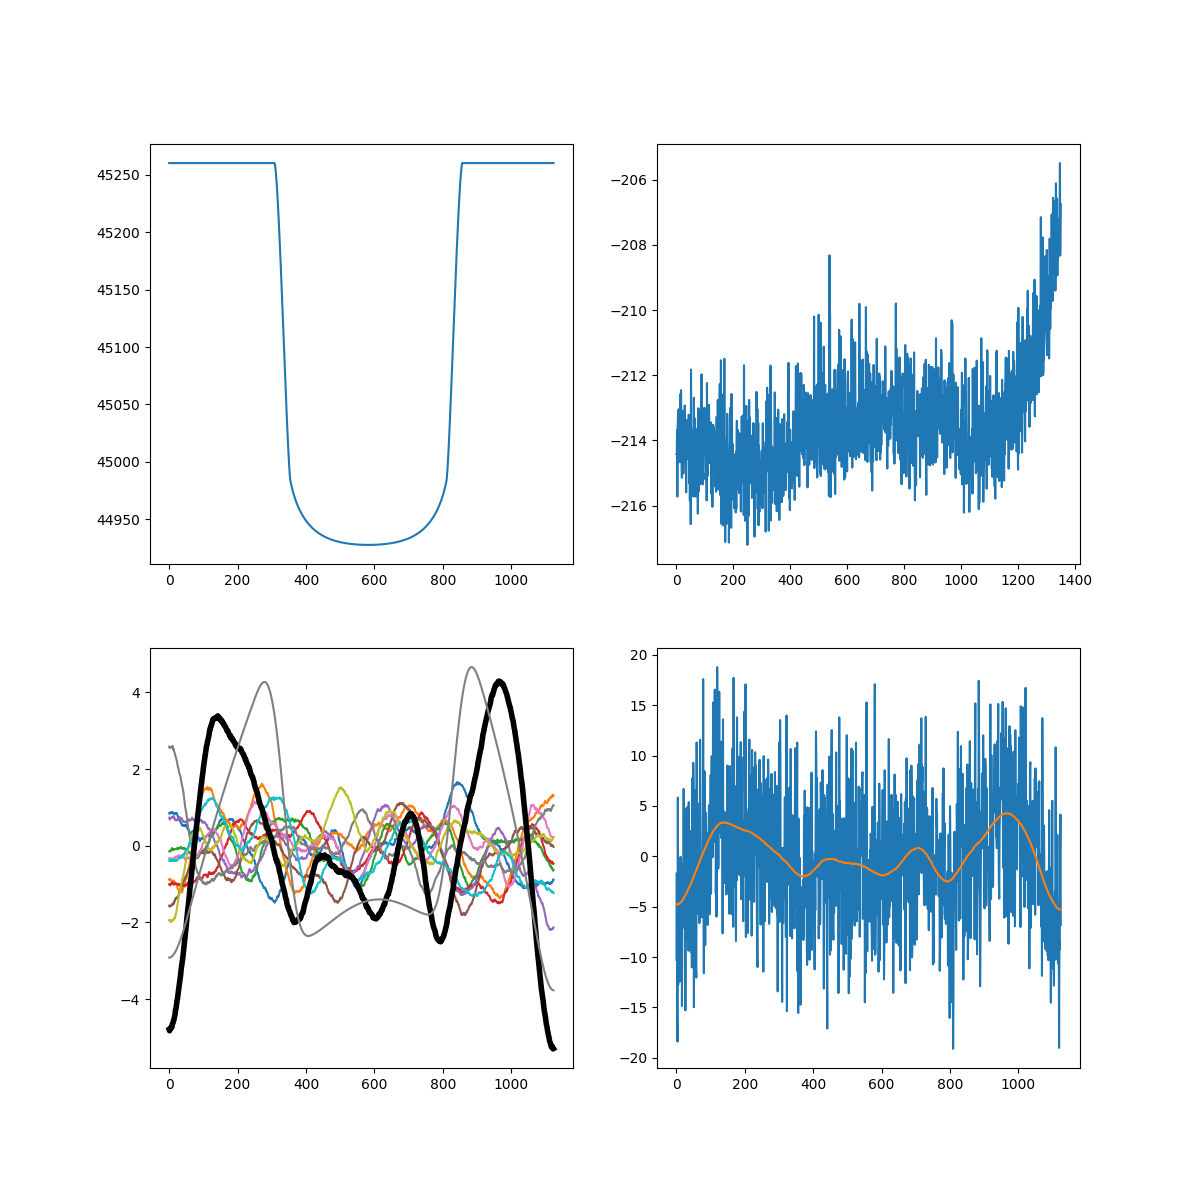

309 3.706509881307586e-05 0.0003066487117867886 8.273246844241754
(1125,) (1125, 4)


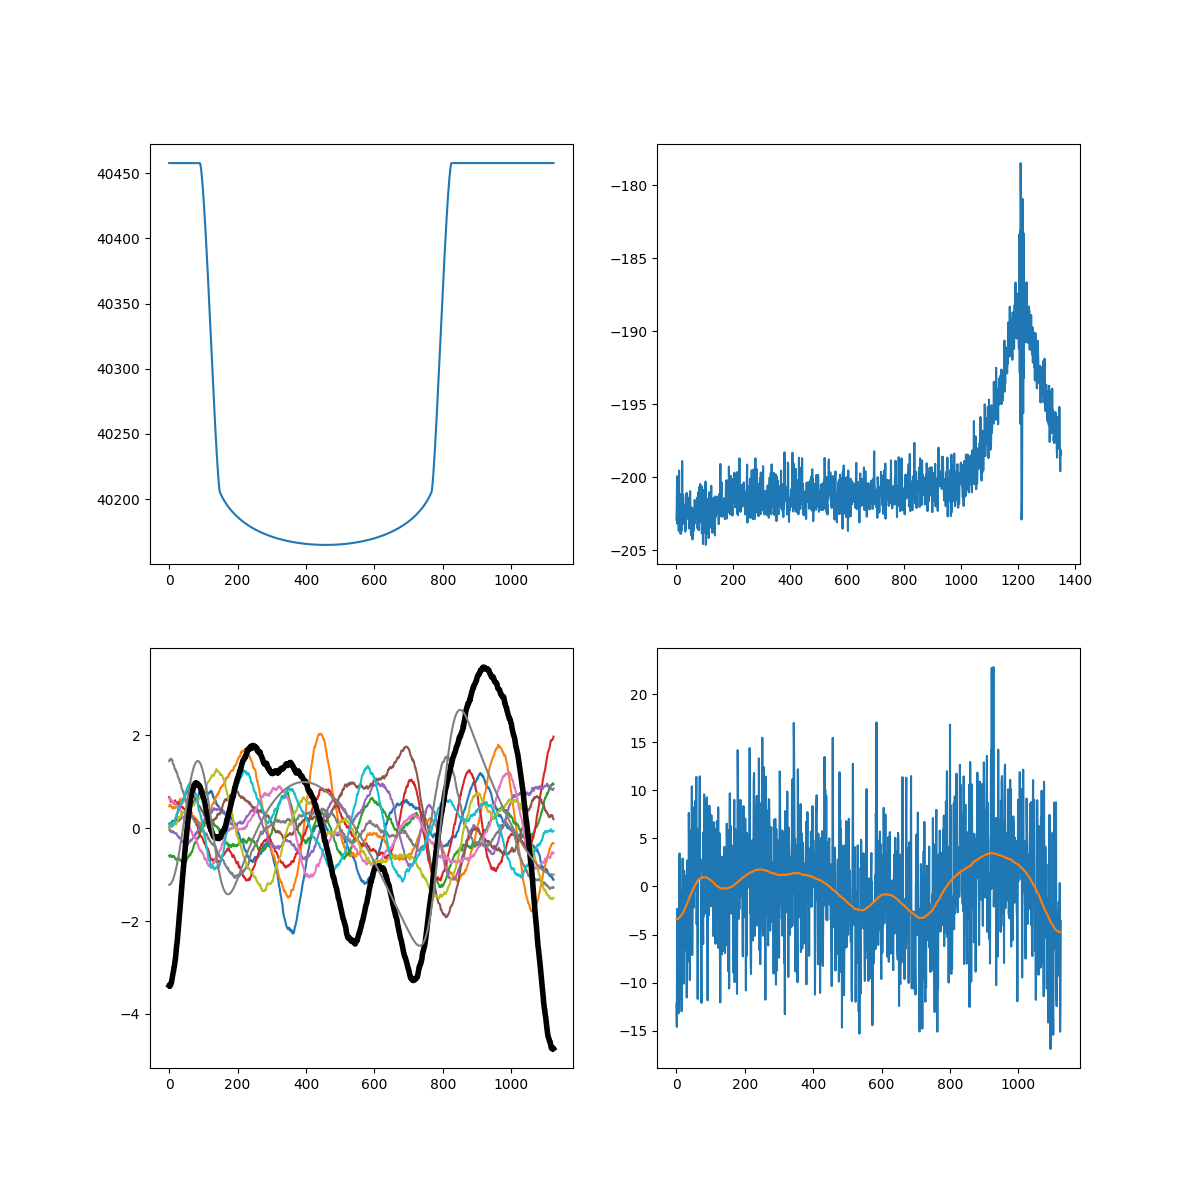

959 3.498753081047229e-05 0.00028828939636955074 8.239775419740722
(1125,) (1125, 4)


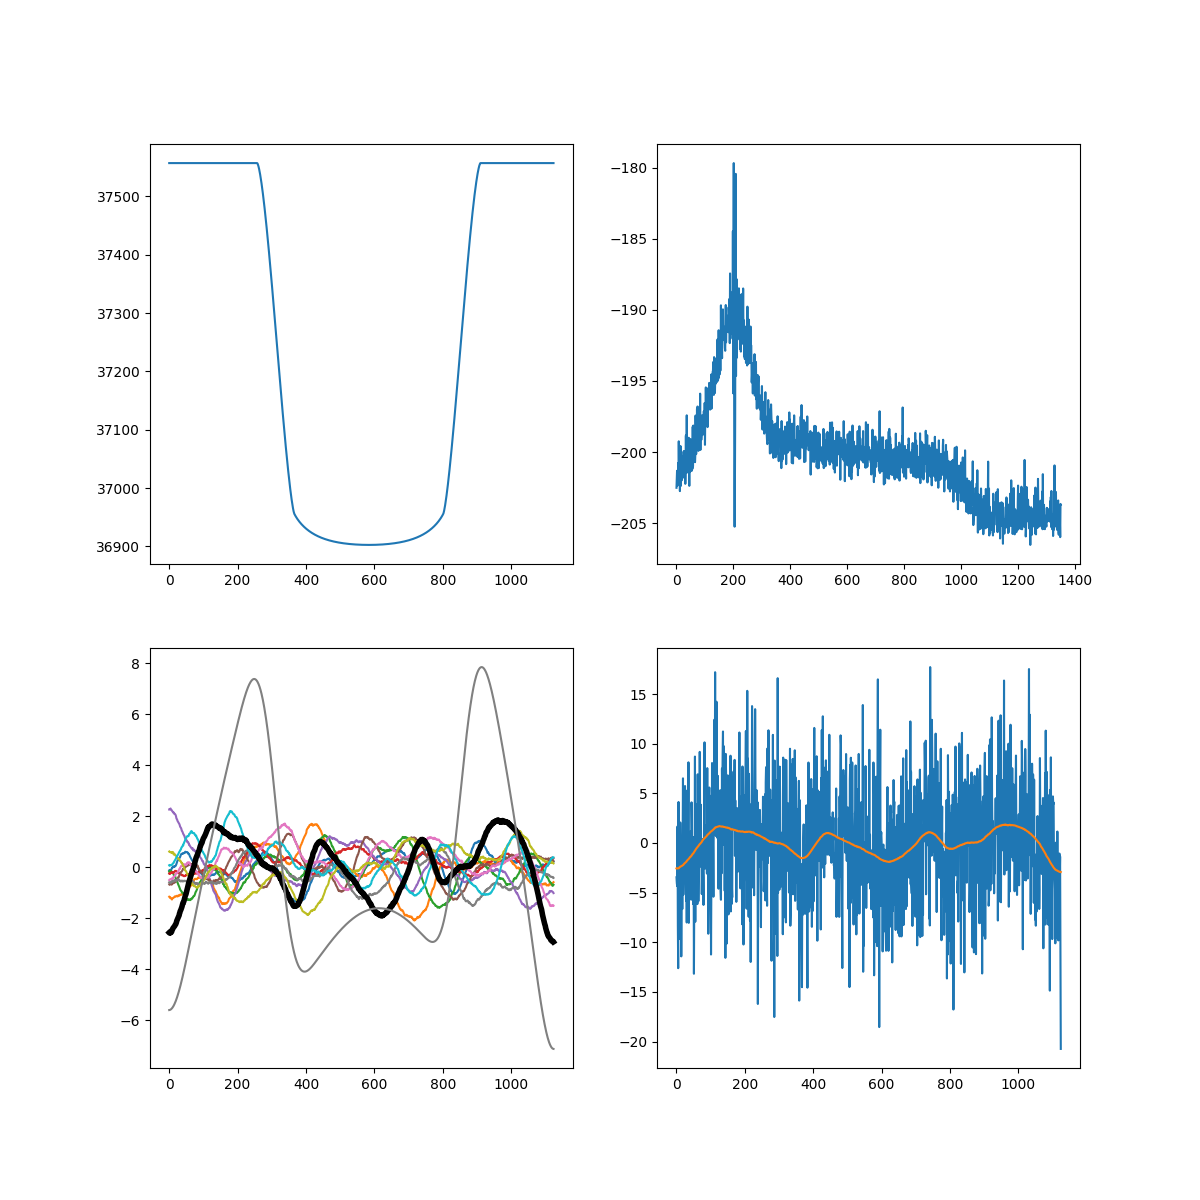

1080 2.9674485706707148e-05 0.0002148694101700785 7.240880677555023
(1125,) (1125, 4)


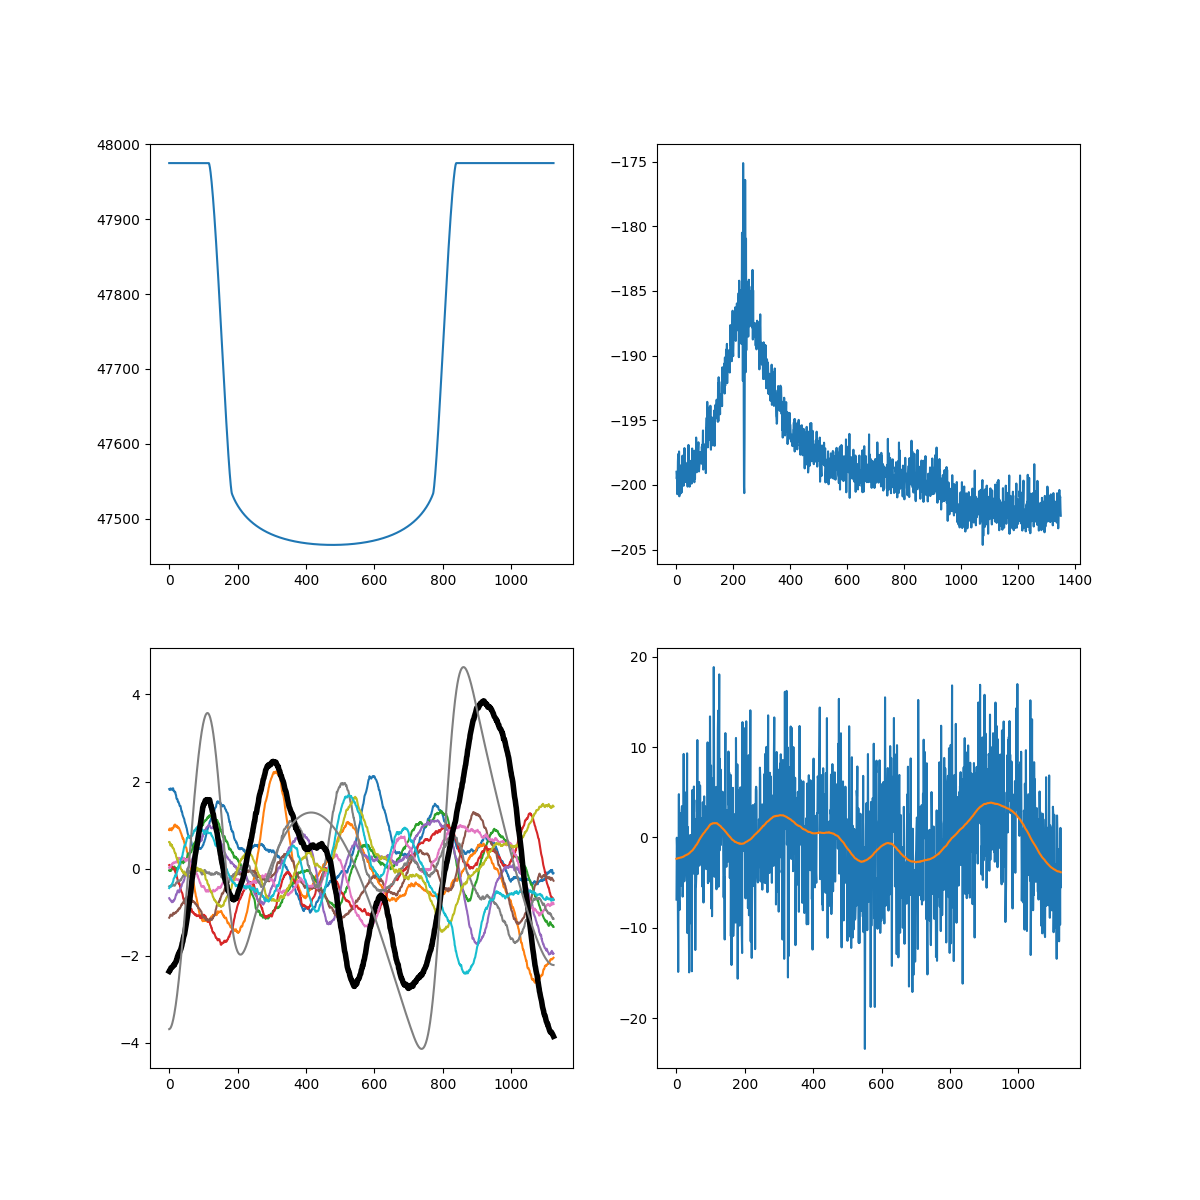

85 2.5923635145673732e-05 0.00018754410749161432 7.234483375411671
(1125,) (1125, 4)


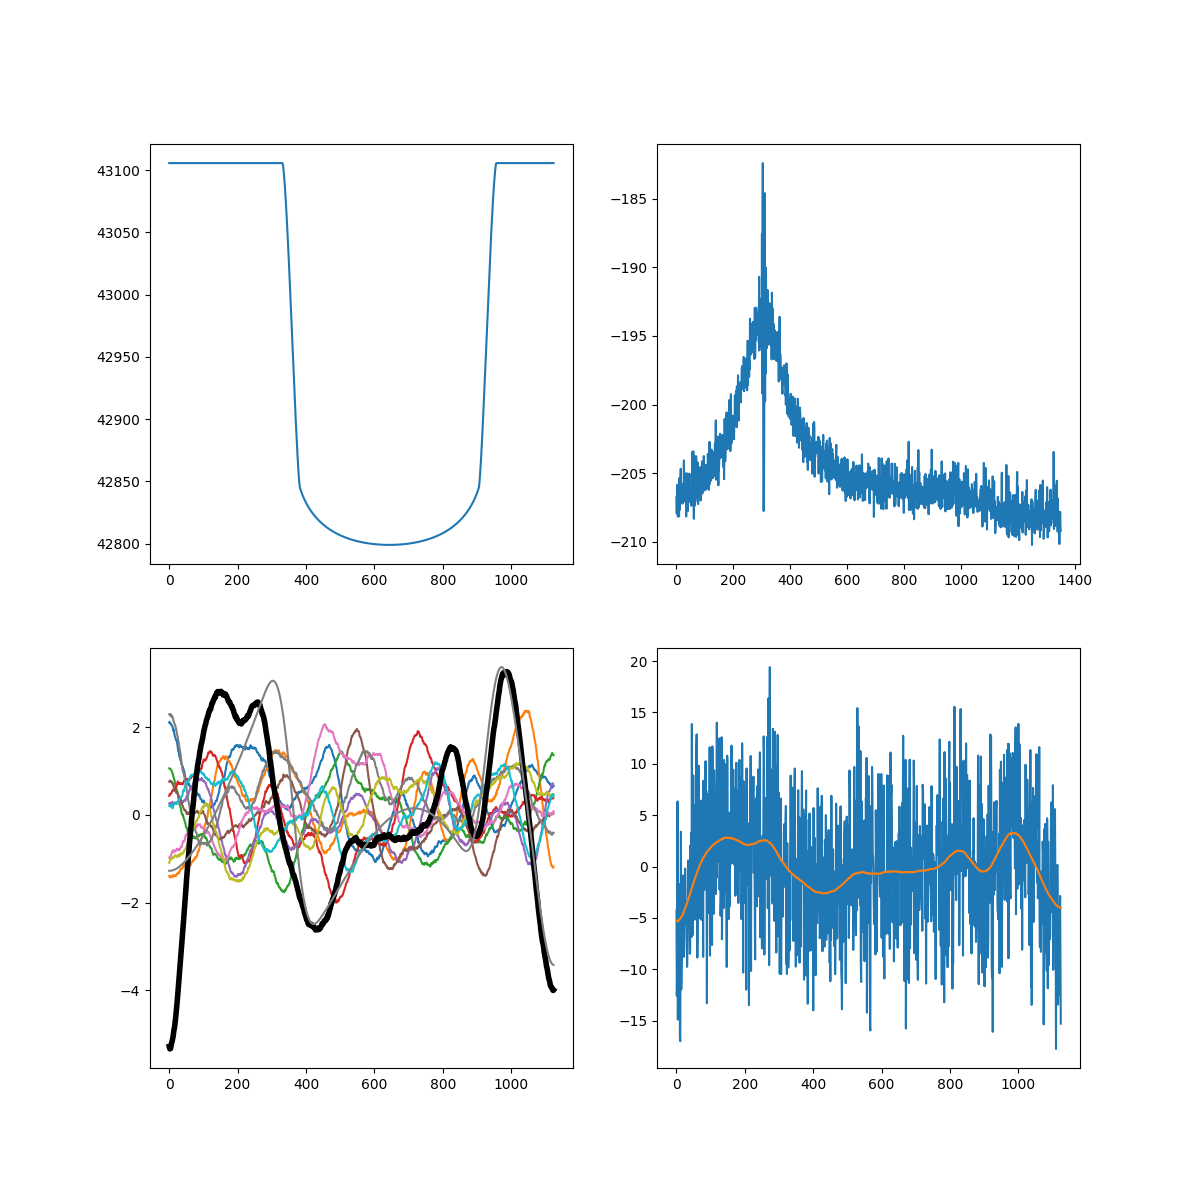

777 1.9696547475363224e-05 0.00014027448525365255 7.121780374408777
(1125,) (1125, 4)


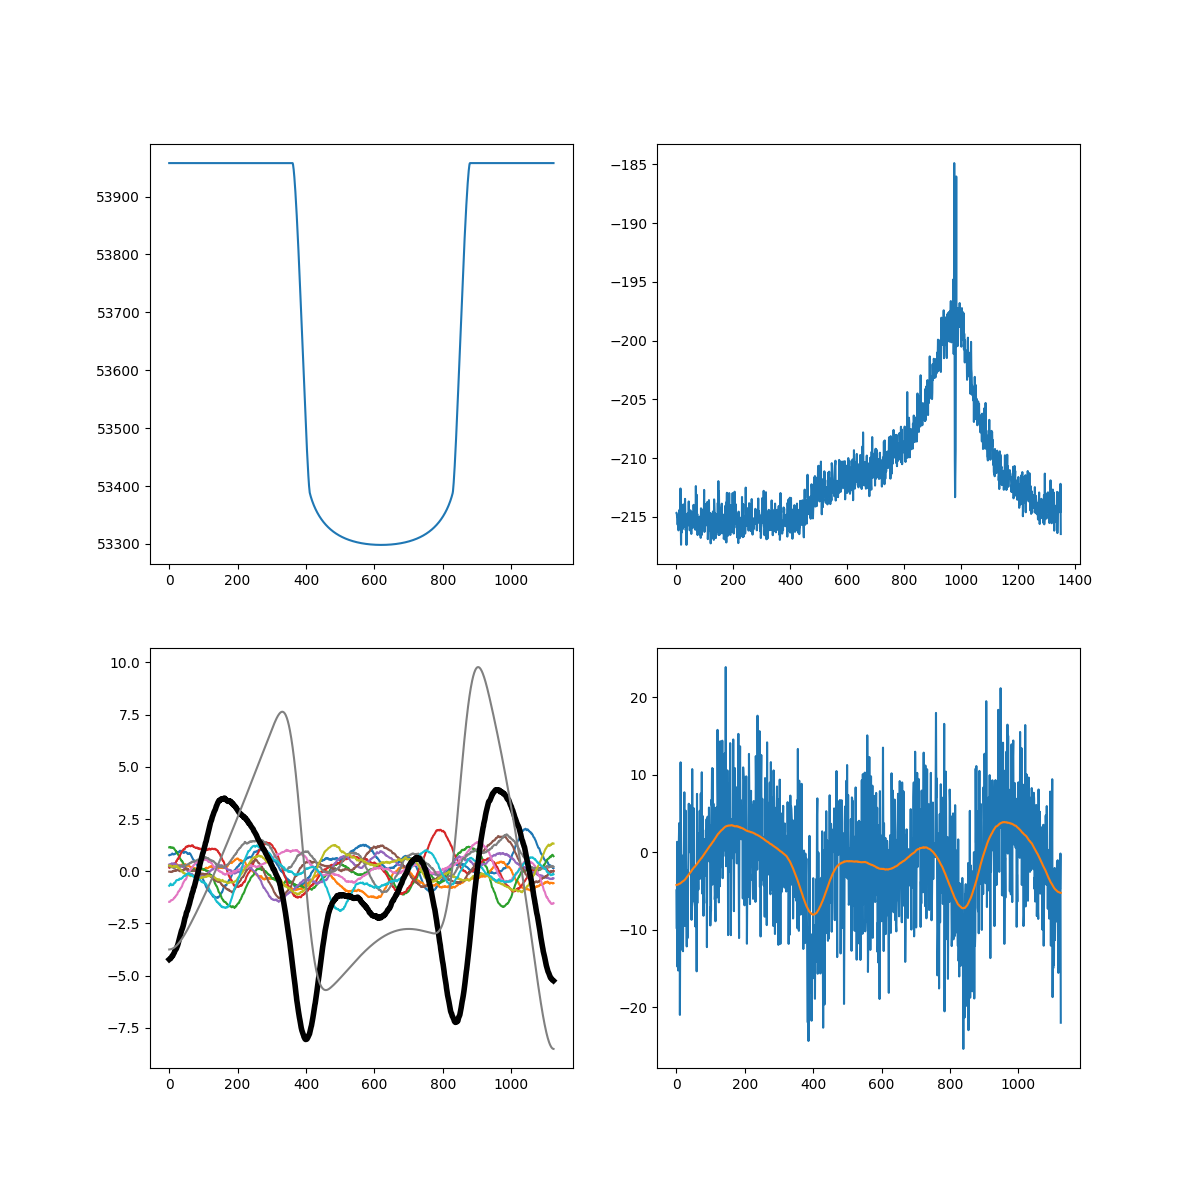

In [13]:
from IPython.display import display
#plt.close('all')
slic = slice(1,282)
sigma_est = [np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data]
error = np.mean(error_matrix[:,slic],1)
ratio = error/sigma_est
order = np.argsort(ratio)[::-1]
ratio[order]
for ind in order[:10]:
    if sigma_est[ind]<0.00004:
        print(ind, sigma_est[ind], error[ind], ratio[ind])
        fig,ax = plt.subplots(2,2,figsize=(12,12))
        plt.sca(ax[0,0])
        transit = np.mean(AIRS_transits[ind,...],1)
        plt.plot(transit)    
        plt.sca(ax[1,1])
        noise = np.mean(AIRS_noise[ind,...],1)[:,None]
        plt.plot(noise)    
        XX=(30,0.001)
        plt.plot(kgs.gaussian_2D_filter_with_nans(noise,XX))    
        sigma = prior_sigma[ind][1:]/np.sqrt(dat_example.transits[0].data[1].time_intervals[0].get())

        #artificial_noise = np.random.default_rng(seed=ind).normal(0,sigma,[10,FGS_noise[ind,...].shape[0]])
        # plt.figure()
        # plt.plot(artificial_noise.T)
        plt.sca(ax[1,0])
        for ii in range(10):
            artificial_noise = sigma*np.random.default_rng(seed=ind+10000*ii).normal(0,1,AIRS_noise[ind,...].shape)    
            artificial_noise = np.mean(artificial_noise,1)[:,None]
            plt.plot(kgs.gaussian_2D_filter_with_nans(artificial_noise,XX))
        plt.plot(kgs.gaussian_2D_filter_with_nans(noise,XX), color='black', linewidth=4)

        d=copy.deepcopy(train_data[ind])
        loaders = ariel_load.default_loaders()
        #loaders[0].cache_steps=[]
        d.load_to_step(5,loaders)
        plt.sca(ax[0,1])
        plt.plot(d.transits[0].diagnostics['FGS_jitter'])
        plt.sca(ax[1,0])
        y = transit
        dm=model.results['model_mean'].m['signal'].m['main'].m['drift'].m['AIRS'].model.m['spectral'].basis_functions[::317250//1125,:3]
        dm=np.concatenate((dm, np.ones((1125,1))), 1)
        print(y.shape,dm.shape)
        coeffs = np.linalg.lstsq(dm, y, rcond=None)
        transit_filtered = (transit-dm@coeffs[0])[:,None]
        transit_filtered = kgs.gaussian_2D_filter_with_nans(transit_filtered,XX)
        plt.plot(0.03*transit_filtered, color = 'gray')
        plt.show()
        #display(fig)
        #fig.canvas.toolbar_visible = False
        fig.canvas.header_visible = False
        fig.canvas.footer_visible = False
        fig.canvas.draw_idle()
        #plt.pause(0.001)

In [11]:
model.results['model_mean'].m['signal'].m['main'].m['drift'].m['AIRS'].model.m['spectral'].basis_functions[::317250//1125,:3]

array([[-1.        ,  1.        , -1.        ],
       [-0.99822064,  0.99288889, -0.98402374],
       [-0.99644128,  0.98579045, -0.96812332],
       ...,
       [ 0.99644128,  0.98579045,  0.96812332],
       [ 0.99822064,  0.99288889,  0.98402374],
       [ 1.        ,  1.        ,  1.        ]])

In [15]:
model2._cached_result

AttributeError: 'Transit' object has no attribute 'diagnostics'